In [1]:
%cd ..

C:\Users\Behnia2P2\Navid\Projects\dreye


In [2]:
import numpy as np
import dreye
from dreye.stimuli.hyperspectral import baden_unpacking as bu
from dreye.estimators.dependent_excitation_models import DependentExcitationFit
import matplotlib.pyplot as plt

c:\users\behnia2p2\navid\projects\axolotl\axolotl\__init__.py:17: UserWarning: ATTENTION: Unable to setup necessary loris configuration to connect to database!!!
Once the issue is resolved, can connect to the database by trying to import the `conn` method: `from axolotl.sql import conn`
This is the error that popped up:
No module named 'loris_config_files'
  warnings.warn(


In [23]:
# path to raw data
path = 'dreye/stimuli/hyperspectral/alldata_formatted_cactus.txt'

In [24]:
image_array = np.genfromtxt(path, delimiter=',', dtype='float64', missing_values=('-inf'))

In [25]:
image_array.shape

(800, 1000)

In [26]:
data, wls = bu.preprocess_baden(image_array)

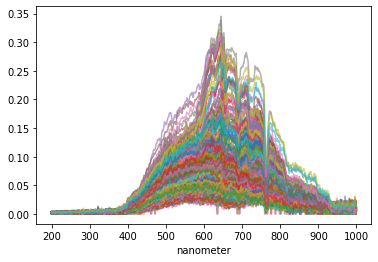

In [29]:
for i in range(data.shape[0]):
    plt.plot(wls, data[:,i], alpha=0.6)

In [ ]:
#TODO arrange 

In [30]:
mspectra = dreye.create_measured_spectra_container(
    [450, 505, 620]
)

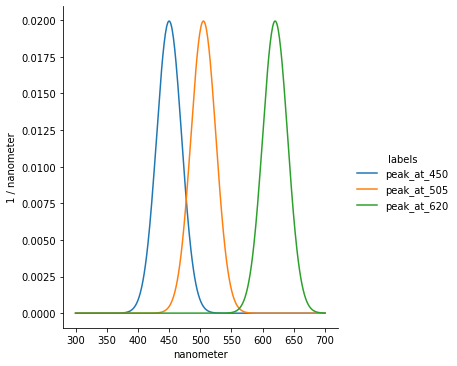

In [31]:
mspectra.normalized_spectra.plot()

In [32]:
mspectra.intensity_bounds

(array([0., 0., 0.]), array([100., 100., 100.]))

In [33]:
pr_model = dreye.create_photoreceptor_model(
    [360, 380, 430, 480, 550]
)

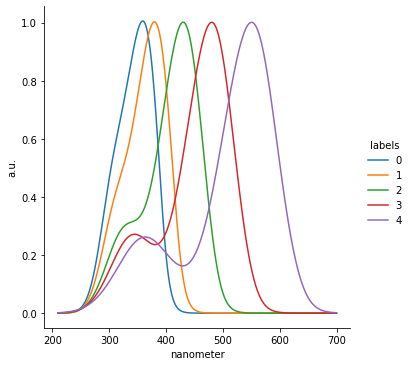

In [34]:
pr_model.sensitivity.plot()